In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train_dir="/kaggle/input/signature-verification-dataset/sign_data/train/"
test_dir="/kaggle/input/signature-verification-dataset/sign_data/test/"

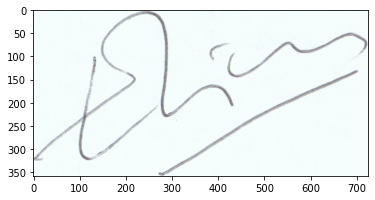

In [3]:
import matplotlib.pyplot as plt
img = plt.imread('../input/signature-verification-dataset/sign_data/train/001/001_01.PNG')
plt.imshow(img)

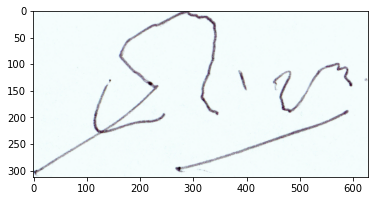

In [4]:
img1 = plt.imread('../input/signature-verification-dataset/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)

In [5]:
SIZE = 224

In [6]:
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir('../input/signature-verification-dataset/sign_data/train/'):
    for data in glob.glob('../input/signature-verification-dataset/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data

test_data = []
test_labels = []

for per in os.listdir('../input/signature-verification-dataset/sign_data/test/'):
    for data in glob.glob('../input/signature-verification-dataset/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [7]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [8]:
train_data.shape

(1649, 1, 224, 224, 3)

In [9]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [10]:
train_data.shape

(1649, 224, 224, 3)

In [11]:
train_labels.shape

(1649, 2)

In [12]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [14]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]


EPOCHS = 20
BS = 64
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)

Epoch 1/20
19/19 [==============================] - 10s 527ms/step - loss: 0.7287 - accuracy: 0.5693 - val_loss: 0.7249 - val_accuracy: 0.5172
Epoch 2/20
19/19 [==============================] - 8s 414ms/step - loss: 0.5999 - accuracy: 0.6733 - val_loss: 0.9549 - val_accuracy: 0.5616
Epoch 3/20
19/19 [==============================] - 8s 417ms/step - loss: 0.6317 - accuracy: 0.6638 - val_loss: 0.9263 - val_accuracy: 0.5515
Epoch 4/20
19/19 [==============================] - 8s 419ms/step - loss: 0.3346 - accuracy: 0.8579 - val_loss: 0.5642 - val_accuracy: 0.8222
Epoch 5/20
19/19 [==============================] - 8s 416ms/step - loss: 0.2581 - accuracy: 0.9038 - val_loss: 0.1686 - val_accuracy: 0.9414
Epoch 6/20
19/19 [==============================] - 8s 414ms/step - loss: 0.2534 - accuracy: 0.9055 - val_loss: 0.1421 - val_accuracy: 0.9515
Epoch 7/20
19/19 [==============================] - 8s 415ms/step - loss: 0.1104 - accuracy: 0.9549 - val_loss: 0.0922 - val_accuracy: 0.9556
Epoch

<Figure size 432x288 with 0 Axes>

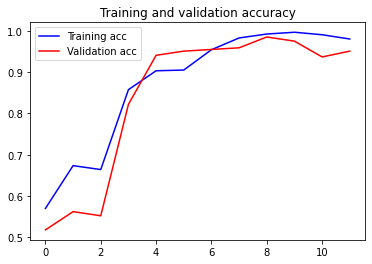

<Figure size 432x288 with 0 Axes>

In [16]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

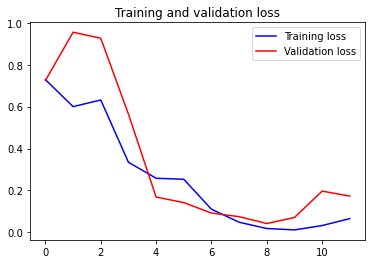

In [17]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [18]:
pred = model.predict(test_data)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(pred,axis=1), test_labels)

1.0